# 基于 TensorFlow 在 SecretFlow 中实现水平联邦音频分类任务

## 引言
本教程基于 TensorFlow 的 [Simple audio recognition: Recognizing keywords](https://tensorflow.google.cn/tutorials/audio/simple_audio) 而改写，通过本教程，您将了解到现有的基于 TensorFlow 的示例如何快速地迁移到 SecretFlow 隐语的联邦学习框架之下，实现模型的联邦学习化。

本教程基于 TensorFlow 的而改写，通过本教程，您将了解到现有的基于 TensorFlow 的示例如何可以快速地迁移到 SecretFlow 隐语的联邦学习框架之下，实现模型的联邦学习化。

## 单机模式

### 小节引言
本小节的代码主要来自于 [Simple audio recognition: Recognizing keywords](https://tensorflow.google.cn/tutorials/audio/simple_audio)  ，主要讲解如何在 TensorFlow 下构建一个基础的自动语音识别（[automatic speech recognition](https://en.wikipedia.org/wiki/Speech_recognition) , ASR）模型识别 10 个不同的词。 在本次示例，教程通过在数据集 [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) ([Warden, 2018](https://arxiv.org/abs/1804.03209)) 的部分数据上训练模型。 为了教程的简洁，本小节仅仅简要介绍了一下各部分的功能；对于实现的具体解析，请读者移步参考[原教程](https://tensorflow.google.cn/tutorials/audio/simple_audio)。

### 环境建立

In [1]:
# !pip install -U -q tensorflow tensorflow_datasets

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2023-10-22 15:02:51.130571: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-22 15:02:51.299539: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-22 15:02:51.304407: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-22 15:02:51.304433: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

### 导入迷你版 Speech Commands 数据集


In [3]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir='.',
        cache_subdir='data',
    )

In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['left' 'yes' 'stop' 'up' 'right' 'down' 'no' 'go']


In [5]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both',
)

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.


2023-10-22 15:02:59.530914: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-22 15:02:59.531003: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-10-22 15:02:59.531055: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-10-22 15:02:59.531098: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-10-22 15:02:59.575579: W tensorfl


label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [6]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [7]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels


train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [8]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [9]:
for example_audio, example_labels in train_ds.take(1):
    print(example_audio.shape)
    print(example_labels.shape)

(64, 16000)
(64,)


In [10]:
label_names[[1, 1, 3, 0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

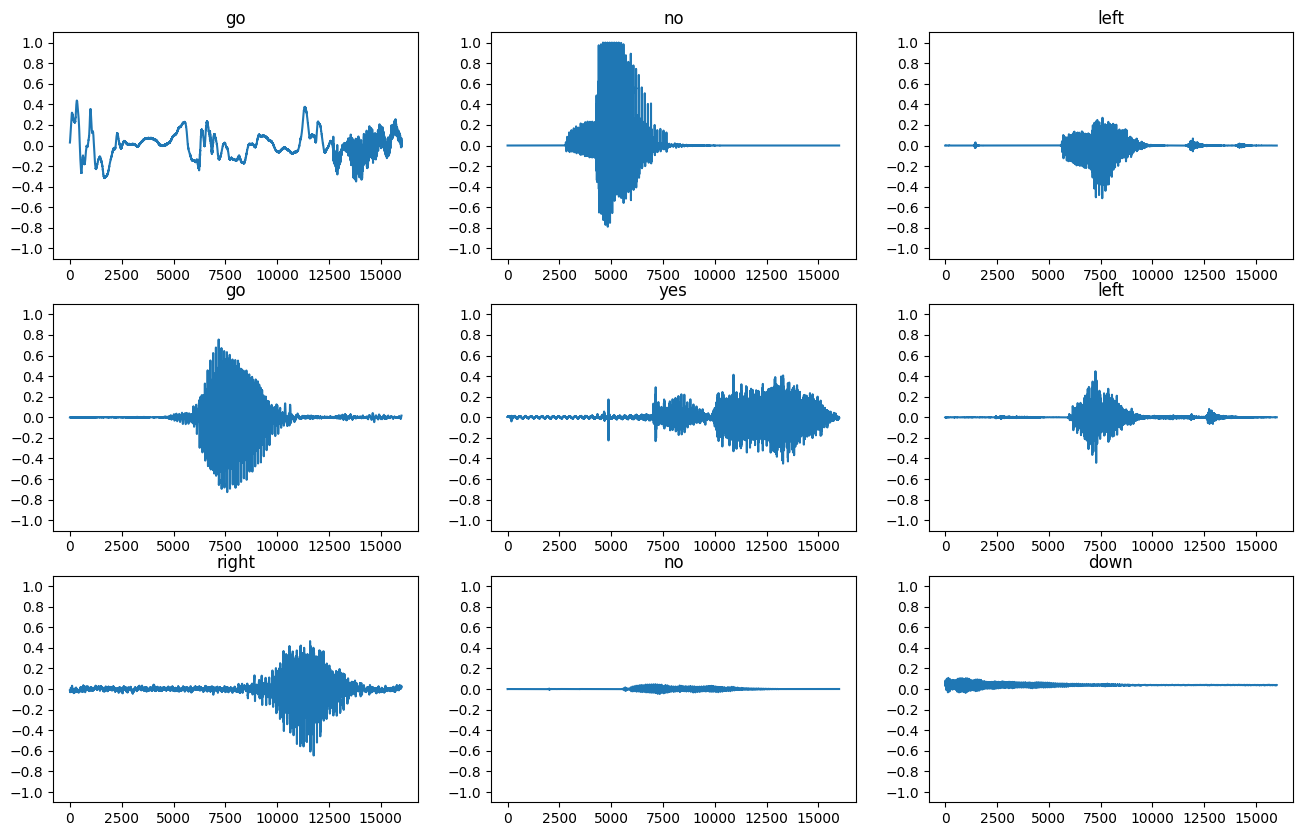

In [11]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i + 1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

### 将波形转换为频谱图

In [12]:
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [13]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [14]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

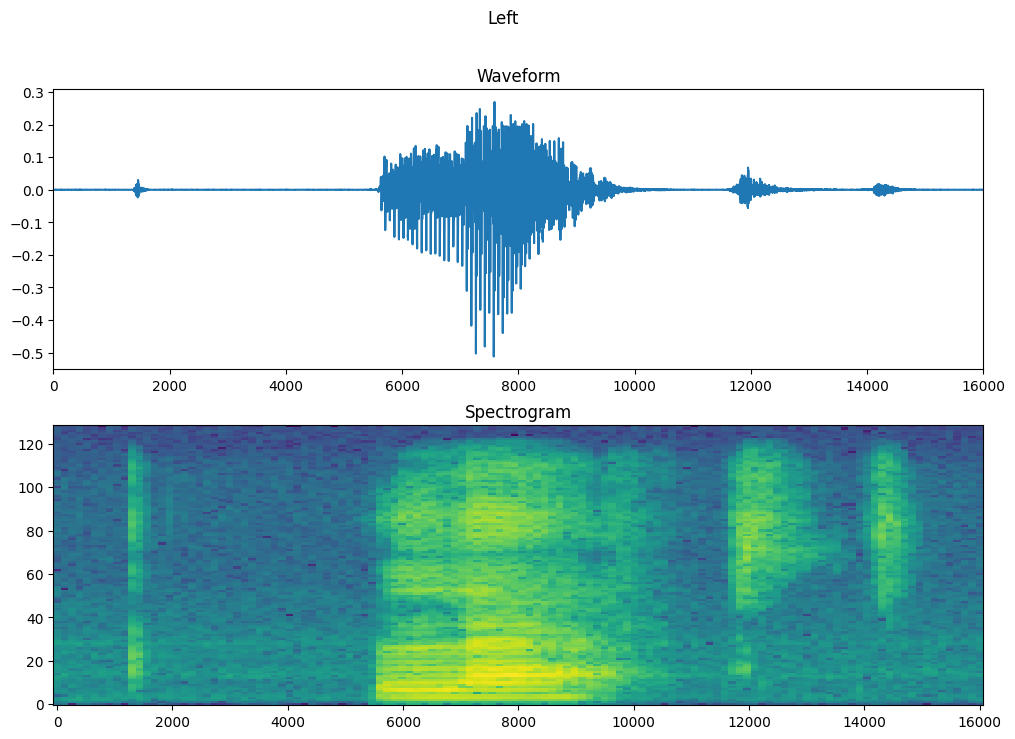

In [15]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [16]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

In [17]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [18]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break

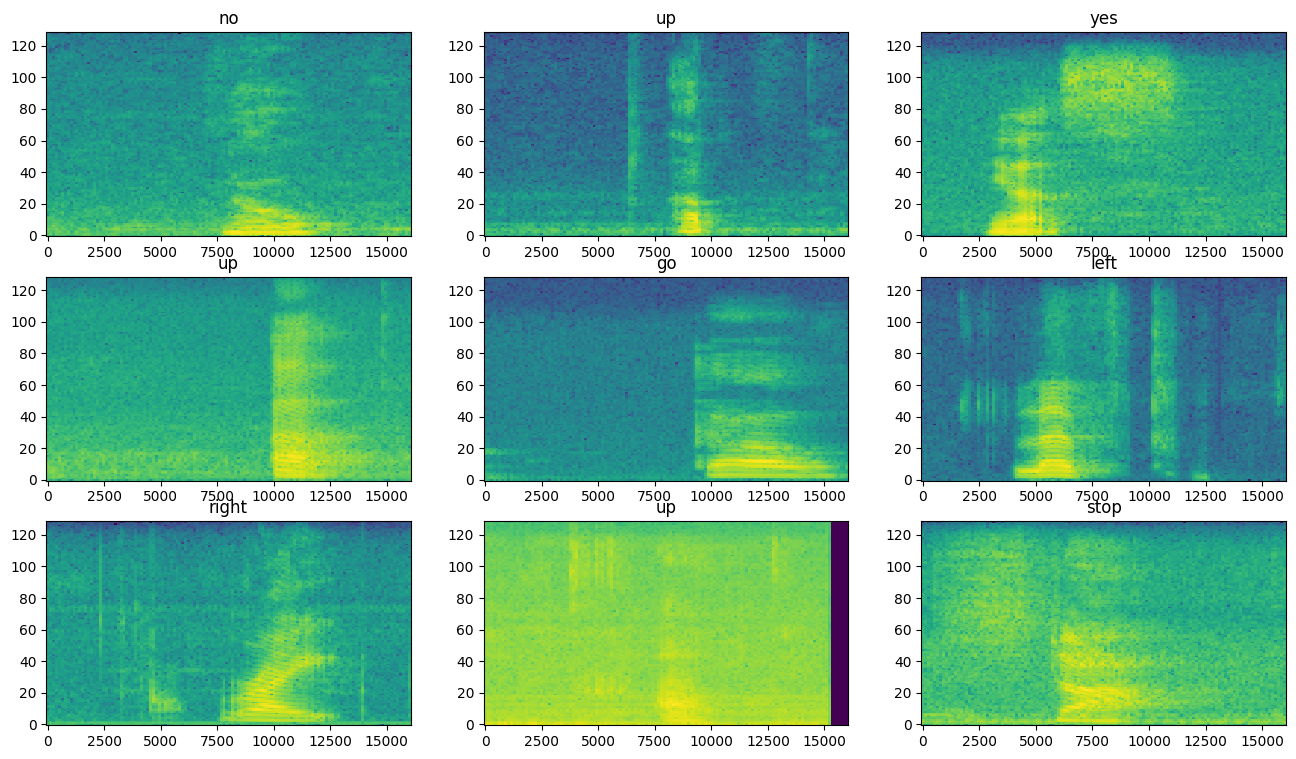

In [19]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

### 构建和训练模型

In [20]:
train_spectrogram_ds = (
    train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [21]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential(
    [
        layers.Input(shape=input_shape),
        # Downsample the input.
        layers.Resizing(32, 32),
        # Normalize.
        norm_layer,
        layers.Conv2D(32, 3, activation='relu'),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_labels),
    ]
)

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [23]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 5s 39ms/step - loss: 1.7643 - accuracy: 0.3547 - val_loss: 1.2982 - val_accuracy: 0.5859
Epoch 2/10
100/100 [==============================] - 4s 37ms/step - loss: 1.1764 - accuracy: 0.5903 - val_loss: 0.9073 - val_accuracy: 0.7214
Epoch 3/10
100/100 [==============================] - 4s 35ms/step - loss: 0.9027 - accuracy: 0.6775 - val_loss: 0.7628 - val_accuracy: 0.7643
Epoch 4/10
100/100 [==============================] - 3s 34ms/step - loss: 0.7352 - accuracy: 0.7387 - val_loss: 0.6755 - val_accuracy: 0.7878
Epoch 5/10
100/100 [==============================] - 3s 35ms/step - loss: 0.6199 - accuracy: 0.7691 - val_loss: 0.6184 - val_accuracy: 0.8164
Epoch 6/10
100/100 [==============================] - 3s 34ms/step - loss: 0.5319 - accuracy: 0.8094 - val_loss: 0.5562 - val_accuracy: 0.8281
Epoch 7/10
100/100 [==============================] - 3s 33ms/step - loss: 0.4732 - accuracy: 0.8292 - val_loss: 0.5163 - val_accuracy: 0.8359

Text(0, 0.5, 'Accuracy [%]')

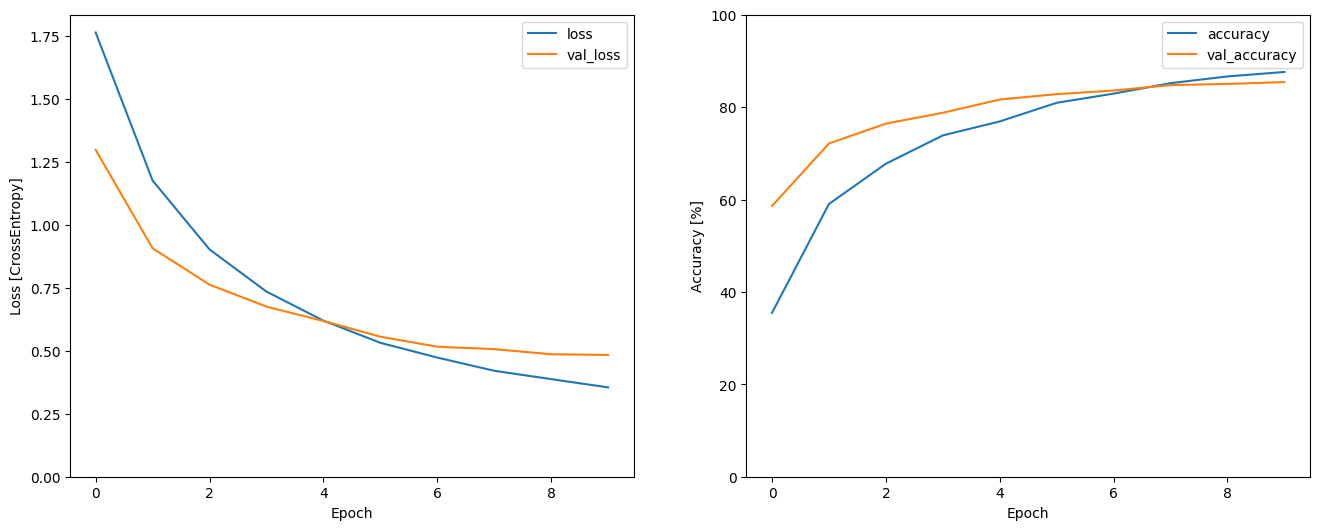

In [24]:
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1, 2, 2)
plt.plot(
    history.epoch,
    100 * np.array(metrics['accuracy']),
    100 * np.array(metrics['val_accuracy']),
)
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### 评估模型性能

In [25]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 0s 15ms/step - loss: 0.5180 - accuracy: 0.8353


{'loss': 0.5179696679115295, 'accuracy': 0.8353365659713745}

#### 展示混淆矩阵

In [26]:
y_pred = model.predict(test_spectrogram_ds)

13/13 [==============================] - 0s 13ms/step


In [27]:
y_pred = tf.argmax(y_pred, axis=1)

In [28]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s, lab: lab)), axis=0)

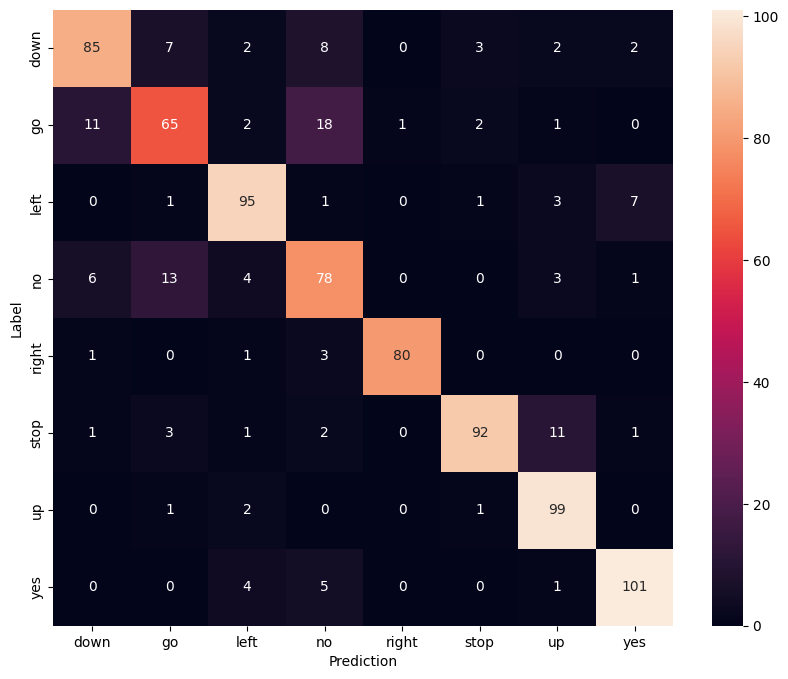

In [29]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_mtx, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g'
)
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

#### 在声音文件上进行推理

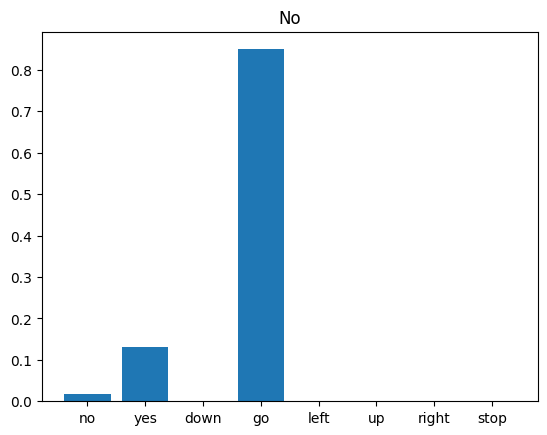

In [30]:
x = data_dir / 'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(
    x,
    desired_channels=1,
    desired_samples=16000,
)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis, ...]

prediction = model(x)
x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

## 联邦模式

### 小节引言
通过单机模式，我们已经学会到，如何在单机模式下使用  ASR 模型实现语音分类，本节我们将看到如何将单机模型如何快速和低成本地迁移到 SecretFlow 隐语的联邦学习框架之下。

### 数据划分

首先为了模拟联邦学习多方参与的场景设定，我们先人为进行一下数据集划分。为方便演示，我们对数据按参与方进行均匀划分。

In [31]:
import os

我们假定联邦学习的数据拥有方是 **alice** 和 **bob**

In [32]:
dataset_name = 'mini_speech_commands'
dataset_path = os.path.join('.', 'data', dataset_name)
parties_list = ['alice', 'bob']
parties_path_list = []

可以看到目前我们的数据集所保存的目录

In [33]:
os.path.abspath(dataset_path)

'/home/limingbo/workshop/secretflow/docs/tutorial/data/mini_speech_commands'

In [34]:
split_dataset_path = os.path.join('.', 'fl-data', dataset_name)

for party in parties_list:
    party_path = os.path.join('.', 'fl-data', dataset_name, party)
    os.makedirs(party_path, exist_ok=True)
    parties_path_list.append(party_path)

由上述结果，我们可以看到，语音分类的训练数据集主要位于 **".data/mini_speech_commands/"** ；我们的参与方数据文件夹分别为 **'./fl-data/mini_speech_commands/alice'** 和 **'./fl-data/mini_speech_commands/bob'**；

In [35]:
parties_path_list

['./fl-data/mini_speech_commands/alice', './fl-data/mini_speech_commands/bob']

In [36]:
commands = os.listdir(dataset_path)

In [37]:
if 'README.md' in commands:
    commands.remove('README.md')
elif '.DS_Store' in commands:
    commands.remove('.DS_Store')

可以看到数据集拥有 8 个标签，所以我们分别在对应的参与方数据文件夹下建立对应的子文件夹

In [38]:
commands

['left', 'yes', 'stop', 'up', 'right', 'down', 'no', 'go']

In [39]:
from os.path import join
import shutil

parties_num = len(parties_list)
for command in commands:
    command_path = join(dataset_path, command)
    for party_path in parties_path_list:
        party_command_path = join(party_path, command)
        print(party_command_path)
        os.makedirs(party_command_path, exist_ok=True)

    index = 0
    for wav_name in os.listdir(command_path):
        wav_path = join(command_path, wav_name)
        target_dir_path = join(
            '.', 'fl-data', dataset_name, parties_list[index % parties_num], command
        )
        shutil.copy(wav_path, target_dir_path)
        # if you want to watch the progress of copying the files, please uncomment the following line
        # print(f'copy {wav_path}-->{target_dir_path}')
        index += 1

./fl-data/mini_speech_commands/alice/left
./fl-data/mini_speech_commands/bob/left
./fl-data/mini_speech_commands/alice/yes
./fl-data/mini_speech_commands/bob/yes
./fl-data/mini_speech_commands/alice/stop
./fl-data/mini_speech_commands/bob/stop
./fl-data/mini_speech_commands/alice/up
./fl-data/mini_speech_commands/bob/up
./fl-data/mini_speech_commands/alice/right
./fl-data/mini_speech_commands/bob/right
./fl-data/mini_speech_commands/alice/down
./fl-data/mini_speech_commands/bob/down
./fl-data/mini_speech_commands/alice/no
./fl-data/mini_speech_commands/bob/no
./fl-data/mini_speech_commands/alice/go
./fl-data/mini_speech_commands/bob/go


查看参与方的各个文件夹下所拥有的文件数目

In [40]:
for command in commands:
    for party_path in parties_path_list:
        command_path = join(party_path, command)
        file_num = len(os.listdir(command_path))
        print(f'{command_path} : {file_num}')

./fl-data/mini_speech_commands/alice/left : 500
./fl-data/mini_speech_commands/bob/left : 500
./fl-data/mini_speech_commands/alice/yes : 500
./fl-data/mini_speech_commands/bob/yes : 500
./fl-data/mini_speech_commands/alice/stop : 500
./fl-data/mini_speech_commands/bob/stop : 500
./fl-data/mini_speech_commands/alice/up : 500
./fl-data/mini_speech_commands/bob/up : 500
./fl-data/mini_speech_commands/alice/right : 500
./fl-data/mini_speech_commands/bob/right : 500
./fl-data/mini_speech_commands/alice/down : 500
./fl-data/mini_speech_commands/bob/down : 500
./fl-data/mini_speech_commands/alice/no : 500
./fl-data/mini_speech_commands/bob/no : 500
./fl-data/mini_speech_commands/alice/go : 500
./fl-data/mini_speech_commands/bob/go : 500


### 隐语环境初始化

In [41]:
import secretflow as sf

# Check the version of your SecretFlow
print('The version of SecretFlow: {}'.format(sf.__version__))

# In case you have a running secretflow runtime already.
sf.shutdown()
sf.init(['alice', 'bob', 'charlie'], address="local", log_to_driver=False)

alice, bob, charlie = sf.PYU('alice'), sf.PYU('bob'), sf.PYU('charlie')

The version of SecretFlow: 1.2.0.dev20231009


2023-10-22 15:03:50,474	INFO worker.py:1538 -- Started a local Ray instance.


### 封装 DataBuilder

在迁移过程，对于数据集的预处理方式，联邦学习模式和单机模式是一样的，我们不再重复。为了完成迁移适配过程，我们只需要参考[在 SecretFlow 中使用自定义 DataBuilder（TensorFlow）](https://github.com/secretflow/secretflow/blob/main/docs/tutorial/CustomDataLoaderTF.ipynb) 封装我们自定义 DataBuilder 即可。现在，参考原教程，我们封装对应的DataBuilder，所以我们也不需要额外写很多代码。

In [42]:
def create_dataset_builder(
    batch_size=32,
):
    def dataset_builder(folder_path, stage="train"):
        import math

        import tensorflow as tf

        dataset = tf.keras.utils.audio_dataset_from_directory(
            directory=folder_path,
            batch_size=batch_size,
            validation_split=0.2,
            seed=0,
            output_sequence_length=16000,
            subset='both',
        )
        # dataset split
        train_dataset = dataset[0]
        eval_dataset = dataset[1]
        # audio preprocess
        train_dataset = train_dataset.map(squeeze, tf.data.AUTOTUNE)
        eval_dataset = eval_dataset.map(squeeze, tf.data.AUTOTUNE)

        train_dataset = make_spec_ds(train_dataset)
        eval_dataset = make_spec_ds(eval_dataset)

        # cache
        train_dataset = train_dataset.cache().prefetch(tf.data.AUTOTUNE)
        eval_dataset = eval_dataset.cache().prefetch(tf.data.AUTOTUNE)

        # split process
        if stage == "train":
            train_step_per_epoch = len(train_dataset)
            return train_dataset, train_step_per_epoch
        elif stage == "eval":
            eval_step_per_epoch = len(eval_dataset)
            return eval_dataset, eval_step_per_epoch

    return dataset_builder

### 构建 dataset_builder_dict

In [43]:
data_builder_dict = {
    alice: create_dataset_builder(
        batch_size=32,
    ),
    bob: create_dataset_builder(
        batch_size=32,
    ),
}

### 定义网络结构

得益于隐语优异的设计，我们只需要将单机模式下定义的网络结构，进行适当的封装即可，这里为了便于演示，我们去除原来的网络结构中依赖数据集的正则化层`norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))`

In [44]:
from tensorflow.keras import layers
from tensorflow.keras import models


def create_audio_classification_model(input_shape, num_classes, name='model'):
    def create_model():
        from tensorflow import keras

        # Create model

        # Instantiate the `tf.keras.layers.Normalization` layer.
        # norm_layer = layers.Normalization()
        # Fit the state of the layer to the spectrograms
        # with `Normalization.adapt`.
        # delete: norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

        model = models.Sequential(
            [
                layers.Input(shape=input_shape),
                # Downsample the input.
                layers.Resizing(32, 32),
                # Normalize.
                # delete: norm_layer,
                layers.Conv2D(32, 3, activation='relu'),
                layers.Conv2D(64, 3, activation='relu'),
                layers.MaxPooling2D(),
                layers.Dropout(0.25),
                layers.Flatten(),
                layers.Dense(128, activation='relu'),
                layers.Dropout(0.5),
                layers.Dense(num_classes),
            ]
        )

        # Compile model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'],
        )
        return model

    return create_model

In [45]:
from secretflow.ml.nn import FLModel
from secretflow.security.aggregation import SecureAggregator

### 定义 TensorFlow 后端的 FLModel 

In [46]:
device_list = [alice, bob]
aggregator = SecureAggregator(charlie, [alice, bob])

# prepare model
num_classes = 8
input_shape = (124, 129, 1)

# keras model
model = create_audio_classification_model(input_shape, num_classes)


fed_model = FLModel(
    device_list=device_list,
    model=model,
    aggregator=aggregator,
    backend="tensorflow",
    strategy="fed_avg_w",
    random_seed=1234,
)

INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party bob.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.tensorflow.strategy.fed_avg_w.PYUFedAvgW'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.tensorflow.strategy.fed_avg_w.PYUFedAvgW'> with party bob.


### 给出参与方数据集路径

In [47]:
parties_path_list

['./fl-data/mini_speech_commands/alice', './fl-data/mini_speech_commands/bob']

In [48]:
data = {
    alice: parties_path_list[0],
    bob: parties_path_list[1],
}

### 训练联邦模型

In [49]:
history = fed_model.fit(
    data,
    None,
    validation_data=data,
    epochs=20,
    batch_size=32,
    aggregate_freq=2,
    sampler_method="batch",
    random_seed=1234,
    dp_spent_step_freq=1,
    dataset_builder=data_builder_dict,
)

INFO:root:FL Train Params: {'x': {PYURuntime(alice): './fl-data/mini_speech_commands/alice', PYURuntime(bob): './fl-data/mini_speech_commands/bob'}, 'y': None, 'batch_size': 32, 'batch_sampling_rate': None, 'epochs': 20, 'verbose': 1, 'callbacks': None, 'validation_data': {PYURuntime(alice): './fl-data/mini_speech_commands/alice', PYURuntime(bob): './fl-data/mini_speech_commands/bob'}, 'shuffle': False, 'class_weight': None, 'sample_weight': None, 'validation_freq': 1, 'aggregate_freq': 2, 'label_decoder': None, 'max_batch_size': 20000, 'prefetch_buffer_size': None, 'sampler_method': 'batch', 'random_seed': 1234, 'dp_spent_step_freq': 1, 'audit_log_dir': None, 'dataset_builder': {PYURuntime(alice): <function create_dataset_builder.<locals>.dataset_builder at 0x7f80780eae50>, PYURuntime(bob): <function create_dataset_builder.<locals>.dataset_builder at 0x7f7f50153940>}, 'wait_steps': 100, 'self': <secretflow.ml.nn.fl.fl_model.FLModel object at 0x7f8113f062e0>}
100%|██████████| 100/100 [

### 可视化训练结果

In [50]:
history.global_history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

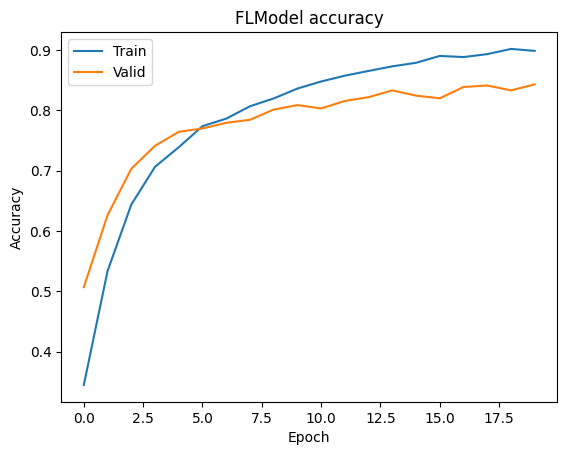

In [51]:
from matplotlib import pyplot as plt

# Draw accuracy values for training & validation
plt.plot(history.global_history['accuracy'])
plt.plot(history.global_history['val_accuracy'])
plt.title('FLModel accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

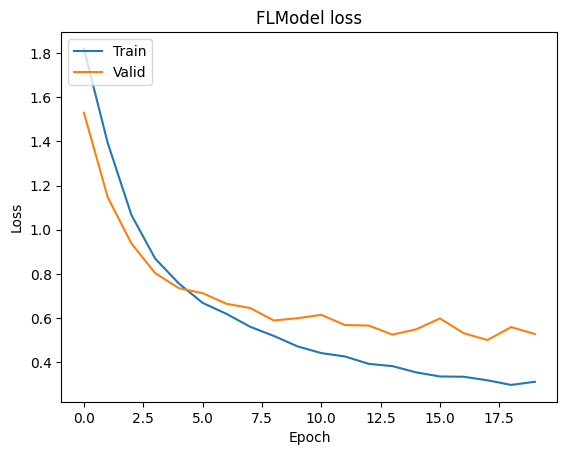

In [52]:
# Draw loss for training & validation
plt.plot(history.global_history['loss'])
plt.plot(history.global_history['val_loss'])
plt.title('FLModel loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

## 小结
通过本教程，您将看到，如何将 TensorFlow 的语音分类模型快速迁移到 SecretFlow 隐语 的联邦学习框架之下，实现语音分类模型的联邦学习。